D:\anaconda3\envs\TSclutering\lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda3\envs\TSclutering\lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13520\2701777612.py:97: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  totcells.append(int(cell.count()))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13520\2701777612.py:98: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.il

<Figure size 640x480 with 0 Axes>

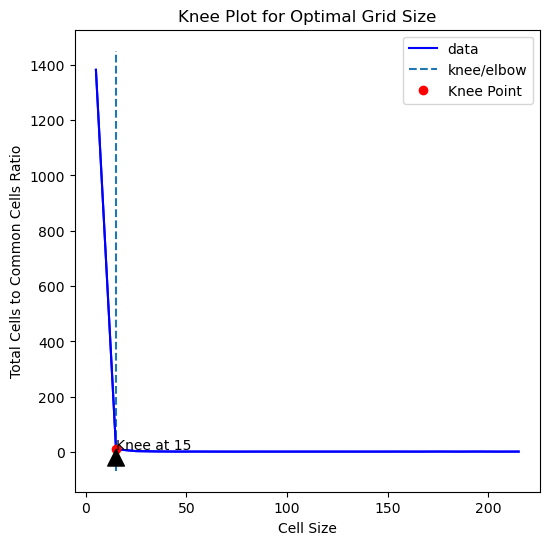

In [1]:
# TS-InSAR time series resampling and reprojection, converting ascending and descending track data into vertical and horizontal grid data
# Perform clustering analysis of TS-InSAR data using PCA and K-Means
# Decompose clustering time series through linear regression and Fast Fourier Transform (FFT)

# Author: Davide Festa (davide.festa@unifi.it)
# Version Date: November 10, 2022

# Create environment from the provided 'gee_environment.yml' file
# Run command >> conda env create -f gee_environment.yml, see: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

# Inputs needed before running the code: 1) Add the path to the subfunctions folder
#                                        2) Path to the InSAR data
#                                        3) Path to the output folder

import sys
sys.path.append(r'F:\PCA-kmeans-TFT-time-series-clustering-and-prediction\InSAR-Time-Series-Clustering\subfunctions') # 1) Add path to subfunctions folder

from kneed import KneeLocator
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# Import subfunctions
import V_H_reprojection
import KMeans_clustering
import PCAnalysis
import regression_DFT
# Import required libraries
from pathlib import Path

# Other code
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Set paths
path_to_InSAR_data = Path("F:\\PCA-kmeans-TFT-time-series-clustering-and-prediction\\InSAR-Time-Series-Clustering\\sample_dataset") # 2) Set path to InSAR data
outpath = Path("F:\\PCA-kmeans-TFT-time-series-clustering-and-prediction\\InSAR-Time-Series-Clustering\\out_data") # 3) Set output folder path
# Read CSV file of ascending InSAR dataset containing "X" "Y" coordinates
ASC = pd.read_csv(path_to_InSAR_data / 'ascending_InSAR_sample.csv', sep=',') 

# Read CSV file of descending InSAR dataset containing "X" "Y" coordinates
DESC = pd.read_csv(path_to_InSAR_data / 'descending_InSAR_sample.csv', sep=',')

datasets_names = ["data_asc", "data_desc"]
# Dictionary containing frames of ascending and descending data
Dataset_asc_desc_dict = dict(zip(datasets_names, [ASC, DESC]))
# Dictionary setup for dictionary holding InSAR time series related information for ascending and descending datasets
data_coordinates = {}
ts = {}
date_ts = {}
date_formatted = {}
df_coords = {}
lats = {}
lons = {}
df_array = {}

# Requirement:
# Columns related to time series should start with "D", and no other columns should start with "D"

for key in Dataset_asc_desc_dict:
    data_coordinates[key] = pd.DataFrame(
        Dataset_asc_desc_dict[key], columns=['X', 'Y'])
    ts[key] = Dataset_asc_desc_dict[key].loc[:, Dataset_asc_desc_dict[key].columns.str.startswith(
        'D')]
    date_ts[key] = list(ts[key].columns.values)
    date_ts[key] = [e[1:] for e in date_ts[key]]
    date_formatted[key] = np.array([dt.datetime.strptime(
        d, '%Y%m%d').date() for d in date_ts[key]])  # Format date names in rows
    date_formatted[key] = list(date_formatted[key])
    ts[key].columns = date_formatted[key]
    # Final dictionary containing array with asc/desc X Y coordinates and time series
    df_coords[key] = pd.concat([data_coordinates[key], ts[key]], axis=1)
    lats[key] = pd.DataFrame(df_coords[key], columns=['X'])
    lons[key] = pd.DataFrame(df_coords[key], columns=['Y'])
    # Dictionary containing arrays of asc/desc time series displacement values only
    df_array[key] = df_coords[key].iloc[:, 2:].to_numpy()
# Retrieve latitudes and longitudes from ascending and descending datasets to set the extent of the fishnet
AscDesc_lats = pd.concat([lats["data_asc"], lats["data_desc"]])
AscDesc_lons = pd.concat([lons["data_asc"], lons["data_desc"]])
Tot_points = pd.concat([AscDesc_lats, AscDesc_lons], axis=1)

# -------------------------- Evaluate Optimal Grid Size ------------------
# Evaluate the best compromise size by finding the minimum grid size that can capture both ascending and descending data
# Assess size by plotting the results of totcells/commoncells against range of n size values
# The inflection point of the plotted curve is the optimal grid size

# Input list for grid sizes
cellsize=list(np.arange(5, 225, 10))
totcells=[]
totcells_to_commoncells=[]

for e in cellsize:
    cell = V_H_reprojection.gridding(Tot_points,e)
    grid_with_asc_desc = V_H_reprojection.grid_dissolve(
        cell, df_coords["data_asc"], df_coords["data_desc"])
    common_indexes=grid_with_asc_desc["data_asc"].index.intersection(grid_with_asc_desc["data_desc"].index)
    totcells.append(int(cell.count()))
    totcells_to_commoncells.append(int(cell.count())/len(common_indexes))

for_grid_size_asses=pd.DataFrame(
    {'cellsize': cellsize,
     'totcells': totcells,
     'totcells_to_commoncells': totcells_to_commoncells
    })

# Create a grid size evaluator
gridsize = KneeLocator(for_grid_size_asses["cellsize"], for_grid_size_asses["totcells_to_commoncells"], curve="convex", direction="decreasing")

# Use KneeLocator to plot the chart
plt.figure()
gridsize.plot_knee()
# Note that label='Data' is no longer added here because the plot_knee method of KneeLocator already includes the legend
plt.plot(for_grid_size_asses["cellsize"], for_grid_size_asses["totcells_to_commoncells"], 'b-')
knee_value = gridsize.knee
plt.plot(knee_value, gridsize.knee_y, 'ro', label='Knee Point')
plt.annotate(f'Knee at {knee_value}', xy=(knee_value, gridsize.knee_y), xytext=(knee_value, gridsize.knee_y + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.legend()
plt.xlabel('Cell Size')
plt.ylabel('Total Cells to Common Cells Ratio')
plt.title('Knee Plot for Optimal Grid Size')
plt.show()



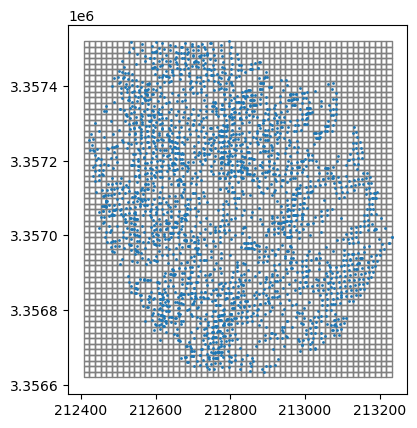

D:\anaconda3\envs\TSclutering\lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda3\envs\TSclutering\lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


<Axes: >

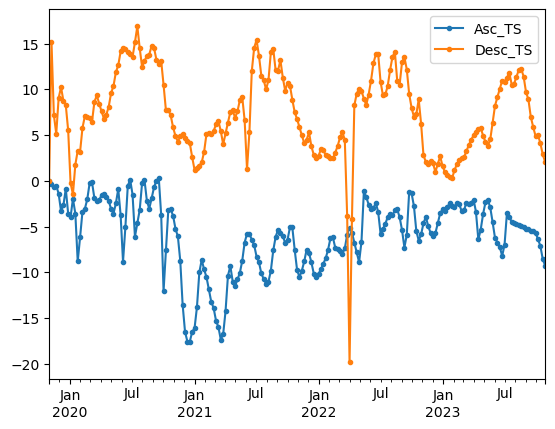

In [2]:
best_grid_size=gridsize.knee

# If you need to manually override the automated grid size selection:
# best_grid_size=

#------------------------------------------------------------------------------

cell=V_H_reprojection.gridding(Tot_points, best_grid_size)

# # Check the gridding result
cell.plot(facecolor="none", edgecolor='grey')
plt.scatter(Tot_points["X"], Tot_points["Y"], s=1)
plt.show()

grid_with_asc_desc = V_H_reprojection.grid_dissolve(
    cell, df_coords["data_asc"], df_coords["data_desc"])

resampled_grid, new_dates = V_H_reprojection.resampling_ts(
    date_formatted["data_asc"], date_formatted["data_desc"], grid_with_asc_desc)
# View the new interpolated time series of ascending and descending tracks
resampled_grid[int(list(resampled_grid.keys())[0])].plot(style='.-')



reprojection successfull


<Axes: >

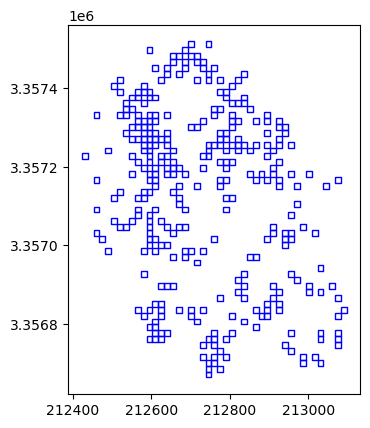

In [3]:
# Function to reproject Asc and Desc displacements into vertical and horizontal components
# Input: resampled grid, Asc LOS angle (radians), Desc LOS angle (radians), need to be adjusted according to the acquisition geometry of the A-DINSAR dataset analyzed
V_H_reprojection.reprojection(resampled_grid, 0.7707, 0.6074)
# Extract the vertical and horizontal displacement time series for PCA and clustering analysis
Vv_df_array = []
Vh_df_array = []

for key in resampled_grid:
    Vv_df_array.append(resampled_grid[key]
                       ["Vv_TS"].to_numpy().reshape((1, -1)))
    Vh_df_array.append(resampled_grid[key]
                       ["Vh_TS"].to_numpy().reshape((1, -1)))

Vv_df_array = np.concatenate(Vv_df_array, axis=0)
Vv_df_array[:, 0] = 0.0
Vh_df_array = np.concatenate(Vh_df_array, axis=0)
Vh_df_array[:, 0] = 0.0

# Remove cells with no data
index_cells_geometry = [x for x in list(
    cell.index) if x in list(resampled_grid.keys())]
geometry_cell = cell.iloc[index_cells_geometry]

# Check the grid after removing empty cells
geometry_cell.plot(facecolor="none", edgecolor='blue')


In [4]:
# Export projected VV, VH data files
import pandas as pd

# Convert the vertical displacement time series into DataFrame
Vv_df = pd.DataFrame(Vv_df_array)
# Set dates as column names
Vv_df.columns = new_dates

# Convert the horizontal displacement time series into DataFrame
Vh_df = pd.DataFrame(Vh_df_array)
# Set dates as column names
Vh_df.columns = new_dates

# Define the path to save files
output_path = "F:\\PCA-kmeans-TFT-time-series-clustering-and-prediction\\InSAR-Time-Series-Clustering\\out_data\\"

# Extract X, Y coordinates
X_coordinates = geometry_cell.centroid.x.to_numpy()
Y_coordinates = geometry_cell.centroid.y.to_numpy()

# Add coordinates to Vv and Vh dataframes
Vv_df['X'] = X_coordinates
Vv_df['Y'] = Y_coordinates

Vh_df['X'] = X_coordinates
Vh_df['Y'] = Y_coordinates

FID = range(len(Vv_df))
Vv_df.insert(0, 'FID', FID)
Vh_df.insert(0, 'FID', FID)

# Output the dataframes to CSV files
Vv_df.to_csv(output_path + "vertical_displacement_timeseries.csv", index=False)
Vh_df.to_csv(output_path + "horizontal_displacement_timeseries.csv", index=False)



Mean value of scaled array is 6.842215866005599e-18
Std value of scaled array is 0.997604786979686
Mean value of scaled array is -2.0526647598016797e-17
Std value of scaled array is 0.997604786979686
PCA explained ratio variance is:
[77.7319  6.6856  3.1994  1.3595  1.0195  0.8762  0.8048  0.6631  0.6068
  0.5238  0.467   0.4347  0.3801  0.3524  0.3189  0.2954  0.2637  0.2538
  0.2241  0.2067  0.204   0.175   0.1597  0.1487  0.1368  0.1302  0.1254
  0.1152  0.102   0.0968  0.0903  0.0883  0.0859  0.084   0.0774  0.0761
  0.0667  0.0644  0.0617  0.0575  0.057   0.0536  0.0511  0.0476  0.0455
  0.0446  0.0417  0.0405  0.0391  0.0371  0.0363  0.0339  0.0319  0.0302
  0.0301  0.0288  0.0266  0.0247  0.0242  0.0227  0.0216  0.0212  0.0203
  0.0186  0.0185  0.0174  0.0158  0.0155  0.0148  0.014   0.0134  0.0129
  0.0127  0.0116  0.011   0.0106  0.0093  0.0091  0.0091  0.0085  0.0081
  0.0076  0.007   0.0069  0.0065  0.0062  0.006   0.0059  0.0055  0.0054
  0.0049  0.0048  0.0044  0.0041  0.0

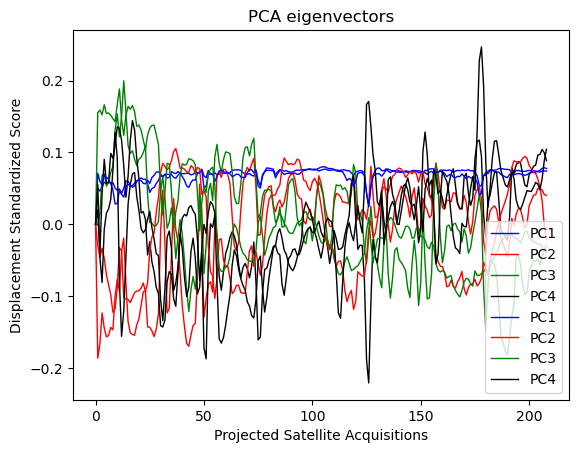

In [5]:
# --------------------------------------PCA Analysis---------------------------
# PCA is used to constrain the number of clusters to be used in unsupervised clustering,
# see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# Analysis is repeatedly performed on both horizontal and vertical time series

# df_array_std should be close to 1, stdarray_mean should be close to 0, stdarray_std is the standardized array
df_array_std, stdarray_mean, stdarray_std = PCAnalysis.std_scaler(
    Vh_df_array)  
df_array_std2, stdarray_mean2, stdarray_std2 = PCAnalysis.std_scaler(
    Vv_df_array)

# PCA_tot_variance is the computed matrix variance value, perc_variance is the same value expressed as a percentage
PCA_tot_variance, perc_variance = PCAnalysis.pca_algorithm(df_array_std)
PCA_tot_variance2, perc_variance2 = PCAnalysis.pca_algorithm(df_array_std2)
# # Function to calculate the number of components needed based on the total percentage of variance we want to retain
#wanted_percentage = PCAnalysis.required_percentage()
#wanted_percentage2 = PCAnalysis.required_percentage()

<Figure size 640x480 with 0 Axes>

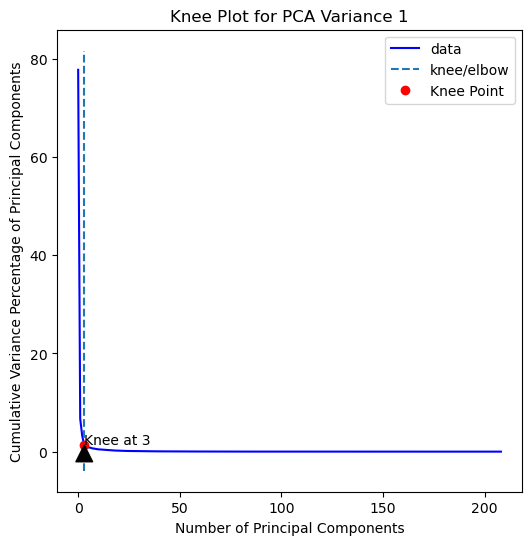

In [6]:
# Automatically find the optimal number of components based on the cutoff value of variance percentage
# Use KneeLocator function to evaluate the best trade-off value of cumulative variance percentage curve
kvh = KneeLocator(np.asarray([(range(len(perc_variance)))]).squeeze(), np.asarray(
    [perc_variance]).squeeze(), curve="convex", direction="decreasing")
kvv = KneeLocator(np.asarray([(range(len(perc_variance2)))]).squeeze(), np.asarray(
    [perc_variance2]).squeeze(), curve="convex", direction="decreasing")


plt.figure()
kvh.plot_knee()
knee_value = kvh.knee
plt.plot(knee_value, kvh.knee_y, 'ro', label='Knee Point')
plt.annotate(f'Knee at {knee_value}', xy=(knee_value, kvh.knee_y), xytext=(knee_value, kvh.knee_y + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Percentage of Principal Components')
plt.legend()
plt.title('Knee Plot for PCA Variance 1')
plt.show()


<Figure size 640x480 with 0 Axes>

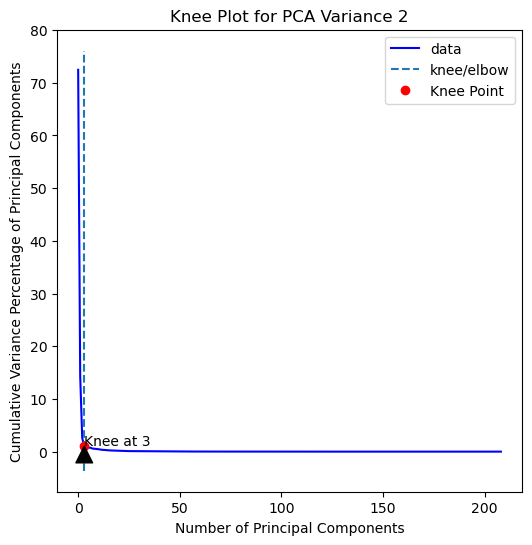

In [7]:
plt.figure()
kvv.plot_knee()
knee_value2 = kvv.knee
plt.plot(knee_value2, kvv.knee_y, 'ro', label='Knee Point')
plt.annotate(f'Knee at {knee_value2}', xy=(knee_value2, kvv.knee_y), xytext=(knee_value2, kvv.knee_y + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Percentage of Principal Components')
plt.legend()
plt.title('Knee Plot for PCA Variance 2')
plt.show()

number_of_components = kvh.knee
number_of_components2 = kvv.knee


D:\anaconda3\envs\TSclutering\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 318 1-dimensional timeseries
  warnings.warn(
D:\anaconda3\envs\TSclutering\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 318 1-dimensional timeseries
  warnings.warn(


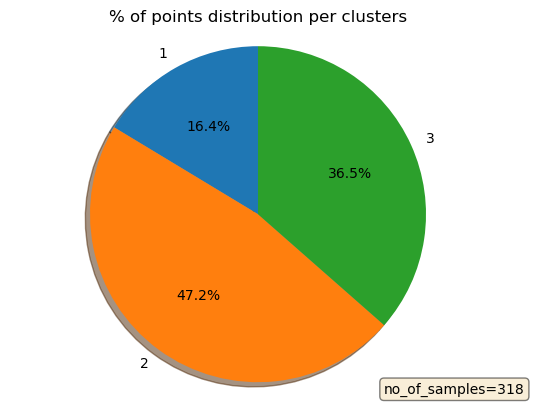

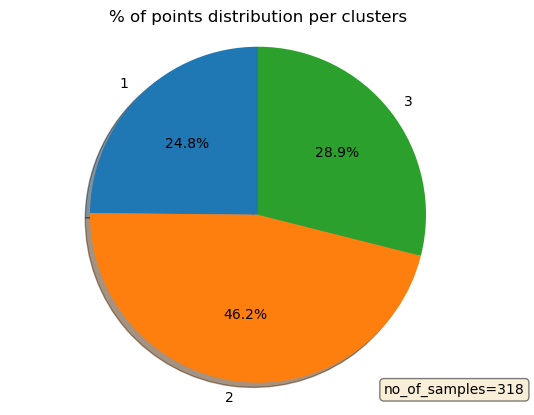

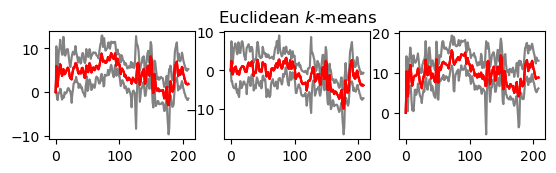

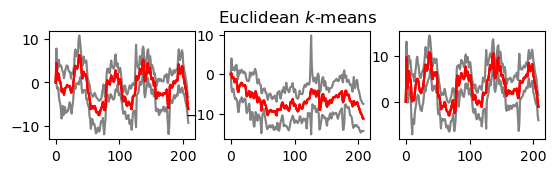

In [8]:
# --------------------------------------Clustering Analysis-----------------------
# For theory, see https://scikit-learn.org/stable/modules/clustering.html
# For parameter settings, see https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html

km, cluster_center, cluster_center_shape, time_series_class, labels, count_labels, inertia = KMeans_clustering.Euclidean_KMeans(
    Vh_df_array, number_of_components)
km2, cluster_center2, cluster_center_shape2, time_series_class2, labels2, count_labels2, inertia2 = KMeans_clustering.Euclidean_KMeans(
    Vv_df_array, number_of_components2)

# Plot the percentage distribution of clusters
KMeans_clustering.cluster_distribution_plotter(
    number_of_components, count_labels, labels)
# plt.savefig('/Clusters_%_distributionVh.png')
KMeans_clustering.cluster_distribution_plotter(
    number_of_components2, count_labels2, labels2)
# plt.savefig('/Clusters_%_distributionVv.png')

# Plot the cluster centers
Vh_clusters_centroids = KMeans_clustering.cluster_center_plotter(
    Vh_df_array, number_of_components, time_series_class, cluster_center)
# plt.savefig('/Clusters_centersVh.png')
Vv_clusters_centroids = KMeans_clustering.cluster_center_plotter(
    Vv_df_array, number_of_components2, time_series_class2, cluster_center2)
# plt.savefig('/Clusters_centersVv.png')

labels = labels+1
labels2 = labels2+1
labels_dataframe = pd.DataFrame(labels, columns=['cluster'])
labels_dataframe2 = pd.DataFrame(labels2, columns=['cluster'])

df_coords_clusters = pd.concat(
    [geometry_cell.reset_index(drop=True), labels_dataframe.reset_index(drop=True), pd.DataFrame(index_cells_geometry, columns=["cell_index"])], axis=1)
df_coords_clusters2 = pd.concat(
    [geometry_cell.reset_index(drop=True), labels_dataframe2.reset_index(drop=True), pd.DataFrame(index_cells_geometry, columns=["cell_index"])], axis=1)

# Export clustering locations as Shapefile
df_coords_clusters.to_file(
    outpath / 'cluster_horizontal_components.shp')
df_coords_clusters2.to_file(
    outpath / 'cluster_vertical_components.shp')


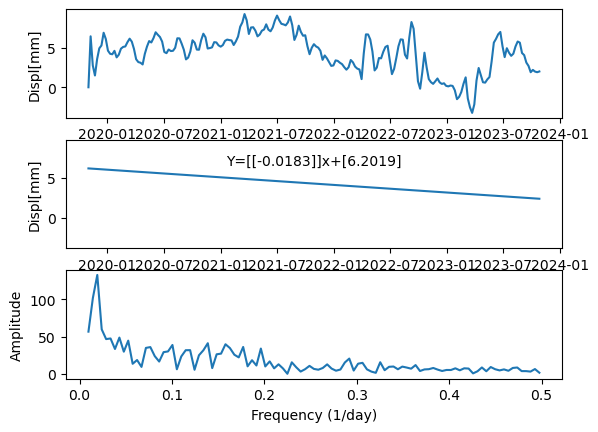

In [9]:
#----------------------------------------- Time Series Decomposition --------------
# For linear regression theory, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# For Fast Fourier Transform theory, see https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html

# Apply decomposition to a result cluster center series
# To decompose the cluster center of interest, manually specify in the following lines:
Vh_clusters_centroid_1=pd.DataFrame(Vh_clusters_centroids[0,:], index=new_dates)

# Function to compute linear regression and DFT of time series
# Input: dates (DatetimeIndex), dataframe containing discrete values of cluster center
# Output: slope of best fit line, intercept of best fit line, root mean square error of regression, dataframe containing the top 6 spectral peaks, converting frequency to relative period
slope, intercept, rmse, powerspectrum = regression_DFT.LinRegression_DFT(new_dates, Vh_clusters_centroid_1)


In [10]:
print(Vh_df_array.shape)
print(Vv_df_array.shape)

(318, 209)
(318, 209)
